## Page Rank with Hadoop and MrJob

PageRank is a link analysis algorithm and it assigns a numerical weight to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set.

Google search uses PageRank algorithm to rank websites in their search engine results. Page rank is one of the algorithms used in search to determine the best search results for a query.

In order to leverage the machinery of Markov Chains to compute the Steady State Distibution, the webgraph needs to be modieifed to ensure irreducibility and aperiodicity.
This is achieved by modifying the page rank formula to following:
using a damping factor and a teleportation factor along with redistributing lost mass 'm' from a dangling node to all of the nodes.

\begin{equation}
PR(n) = \alpha \left(\frac{1}{|G|}\right) + (1-\alpha)\left( \frac{m}{|G|} + \sum_{i \in L(n)} { \frac{PR(i)}{C(i)}} \right)
\end{equation}

##  Section 1: MRJob implementation of a basic PageRank with toy data

A basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input.

The implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]

The data is located here :
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

Or on Amazon: 

> s3://ucb-mids-mls-networks/PageRank-test.txt

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck the work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

### Implementation

In [3]:
%%writefile wikipedia_example.txt
1	{}
2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}

Writing wikipedia_example.txt


In [4]:
# python code to include initial page ranks
# if time permits this can be done using a map reduce job
num_lines = sum(1 for line in open('wikipedia_example.txt'))
with open("wikipedia_example.txt","r") as f:
    with open("wikipedia_example_updated.txt","w+")  as w:
        for line in f.readlines():
            line  = line.strip('\n') + '|' + str(1.0/num_lines) +'\n'
            w.write(line)

In [1]:
!cat wikipedia_example.txt

1	{}
2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}

In [2]:
!cat wikipedia_example_updated.txt

1	{}|0.0909090909091
2	{'3': 1}|0.0909090909091
3	{'2': 1}|0.0909090909091
4	{'1': 1, '2': 1}|0.0909090909091
5	{'4': 1, '2': 1, '6': 1}|0.0909090909091
6	{'2': 1, '5': 1}|0.0909090909091
7	{'2': 1, '5': 1}|0.0909090909091
8	{'2': 1, '5': 1}|0.0909090909091
9	{'2': 1, '5': 1}|0.0909090909091
10	{'5': 1}|0.0909090909091
11	{'5': 1}|0.0909090909091


In [5]:
%%writefile PageRank.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

class PageRank(MRJob):
    
    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            #'mapreduce.text.key.comparator.options': '-k2,2nr -k1,1',
            #'mapred.text.key.comparator.options': '-k2,2nr -k1,1', 
            'mapreduce.job.reduces': 16
        }
    
        return [MRStep(jobconf=JOBCONF_STEP1, 
                       mapper=self.mapper, 
                       reducer=self.reducer),
                MRStep(reducer=self.reducer_pagerank)
                ]
       
    
    
    def configure_options(self):
        super(PageRank, self).configure_options()
        self.add_passthrough_option('--dampingfactor', default='0.85', type=str, help='damping factor')
        self.add_passthrough_option('--numtotalnodes', default=None, type=str, help='total number of nodes in the graph')
    
    
    def mapper(self, _, line):
        node = None
        adjacency_list = None
        initial_page_rank = 0.0
        neighbors = 0 
        if line!= "":
            node, graph_pr_out_links = line.strip().split('\t')
            node =  node.replace('"', '')
        
            adjacency_list, initial_page_rank = map(ast.literal_eval, graph_pr_out_links.strip("\"").strip('"').strip("'").split('|'))
            neighbors = len(adjacency_list)
            
            if neighbors> 0:
                for key in adjacency_list.keys():
                    yield (key),  (1.0* initial_page_rank /neighbors)
                    
            if neighbors== 0:
                yield '**dangling', (1.0* initial_page_rank) 
                
            yield (node), (adjacency_list)
        
    
    def reducer(self, key, values):
        node = None
        adjacency_list = {}
        total = 0.0
        node =  key.strip("'")
        #values = [v  for v in values]
        redistribute_mass = 0.0
        
        
        if node == '**dangling':
            redistribute_mass= sum([float(v) for v in values])
            for i in range(1, int(self.options.numtotalnodes) + 1):
                yield str(i), redistribute_mass
        
        else:
            for pr_out_link in values:
                if type(pr_out_link) == float:
                    total = total + float(pr_out_link)

                elif type(pr_out_link) == dict:
                    adjacency_list = pr_out_link

            yield node , (str(adjacency_list) + '|' + str(total) )
        
    
            
    def reducer_pagerank(self, node, page_rank_adj_lists):
        lost_mass = 0.0
        page_rank = 0.0
        adj_lists = {}
        
        alpha = 1 - float(self.options.dampingfactor)
        total_nodes = float(self.options.numtotalnodes)
        
        for page_rank_adj_list in page_rank_adj_lists:
            if type(page_rank_adj_list) == float:
                lost_mass = page_rank_adj_list
            else:
                adj_lists, page_rank = map(ast.literal_eval, page_rank_adj_list.strip("\"").split('|'))
                    
        page_rank_updated = alpha * (1/total_nodes) + (1-alpha) * (float(lost_mass)/total_nodes + float(page_rank))
                
        yield node, str(adj_lists) + "|" + str(round(page_rank_updated, 6))
                
        
if __name__ == '__main__':
    PageRank.run()        

Writing PageRank.py


In [6]:
%%writefile PageRank_driver.py
# START DRIVER
from PageRank import PageRank
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import ast
import subprocess

INPUT_GRAPH = sys.argv[1]
DAMPING_FACTOR = sys.argv[2]
TOTAL_NODES = sys.argv[3]
MAX_ITERATION = int(sys.argv[4])
MODE = sys.argv[5]

num_interation = 0

if MODE == 'hadoop':
    mr_job = PageRank(args=[INPUT_GRAPH, '--dampingfactor', DAMPING_FACTOR, '--numtotalnodes', TOTAL_NODES,  '-r', 'hadoop', 
                             '--no-output', '--cleanup', 'NONE', '--no-check-input-paths', '--output-dir',  '/tmp/msannat/temp-output' ])
    while (num_interation<MAX_ITERATION):
        with mr_job.make_runner() as runner: 
            num_interation += 1
            print "Iteration: ", num_interation
            subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
            runner.run()
            f = open(INPUT_GRAPH, 'w+')
            cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
            for line in cat.stdout:
                #print line
                f.writelines(line)

        f.close()
else:
    mr_job = PageRank(args=[INPUT_GRAPH, '--dampingfactor', DAMPING_FACTOR, '--numtotalnodes', TOTAL_NODES,  '-r', 'local' ])
    while (num_interation<MAX_ITERATION):
        with mr_job.make_runner() as runner: 
            num_interation += 1
            print "Iteration: ", num_interation
            runner.run()
            f = open(INPUT_GRAPH, 'w+')
            for line in runner.stream_output():
                #print line
                f.writelines(line)

        f.close()
        
# END DRIVER

Writing PageRank_driver.py


In [7]:
!rm ./wikipedia_example_input.txt
!cp ./wikipedia_example_updated.txt ./wikipedia_example_input.txt
!python ./PageRank_driver.py ./wikipedia_example_input.txt 0.85 11 30 'local'

rm: cannot remove `./wikipedia_example_input.txt': No such file or directory
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30


In [8]:
!cat ./wikipedia_example_input.txt

"5"	"{u'2': 1, u'4': 1, u'6': 1}|0.080888"
"6"	"{u'2': 1, u'5': 1}|0.039088"
"7"	"{u'2': 1, u'5': 1}|0.01617"
"8"	"{u'2': 1, u'5': 1}|0.01617"
"9"	"{u'2': 1, u'5': 1}|0.01617"
"1"	"{}|0.032782"
"10"	"{u'5': 1}|0.01617"
"11"	"{u'5': 1}|0.01617"
"2"	"{u'3': 1}|0.383603"
"3"	"{u'2': 1}|0.34372"
"4"	"{u'1': 1, u'2': 1}|0.039088"


### Analysis

The MRJob implmentation of the iterative PageRank algorithm, with teleportation factor and distribution of the dangling nodes mass, when executed on the Wikipedia article example dataset for predefined number of iterations, produces similar PageRank probabilities.

## Section 2: Exploring PageRank teleportation and network plots 


* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in above, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular I would do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note that the plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

###  Implementation

In [9]:
%%writefile explore_pagerank_teleportation_driver.py
####
# Using section 1 implmentation of the iterative PageRank algorithm, run several MRJobs with different
#damping factors: [0,0.25,0.5,0.75, 0.85, 1] and collect resulting pagerank probablities.
####

from PageRank import PageRank
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import ast
import subprocess
from shutil import copyfile
import time

SOURCE_GRAPH = './wikipedia_example_updated.txt'
DAMPING_FACTOR = [0, 0.25, 0.5, 0.75, 0.85, 1]
TOTAL_NODES = 11
MAX_ITERATION = 30
MODE = 'local'

for d in DAMPING_FACTOR:
    print 'Started job with damping factor:', d
    start_time = time.time()
    INPUT_GRAPH = './wikipedia_example_input_with_'+str(d)+'.txt'
    copyfile(SOURCE_GRAPH, INPUT_GRAPH)
   
    mr_job = PageRank(args=[INPUT_GRAPH, '--dampingfactor', str(d), '--numtotalnodes', str(TOTAL_NODES),  '-r', 'local' ])
    num_interation = 0
    while(num_interation<MAX_ITERATION):
        
        with mr_job.make_runner() as runner: 
            
            num_interation += 1
            #print "Iteration: ", num_interation
            runner.run()
        
            f = open(INPUT_GRAPH, 'w+')
            for line in runner.stream_output():
                f.writelines(line)

        f.close()
        
    end_time = time.time()
    print "Time taken = {:.2f} seconds for d = {}".format(end_time - start_time, d)


Writing explore_pagerank_teleportation_driver.py


In [10]:
!python ./explore_pagerank_teleportation_driver.py

Started job with damping factor: 0
Time taken = 22.91 seconds for d = 0
Started job with damping factor: 0.25
Time taken = 22.08 seconds for d = 0.25
Started job with damping factor: 0.5
Time taken = 21.49 seconds for d = 0.5
Started job with damping factor: 0.75
Time taken = 23.58 seconds for d = 0.75
Started job with damping factor: 0.85
Time taken = 22.41 seconds for d = 0.85
Started job with damping factor: 1
Time taken = 22.51 seconds for d = 1


Network graph with damping factor = 0


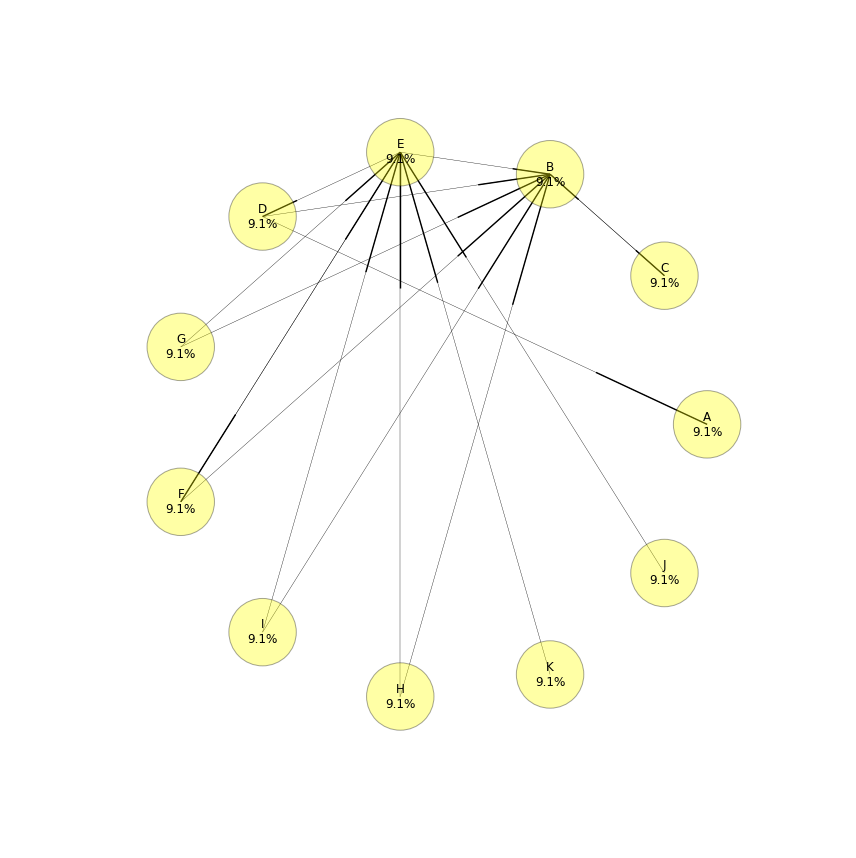

Network graph with damping factor = 0.25


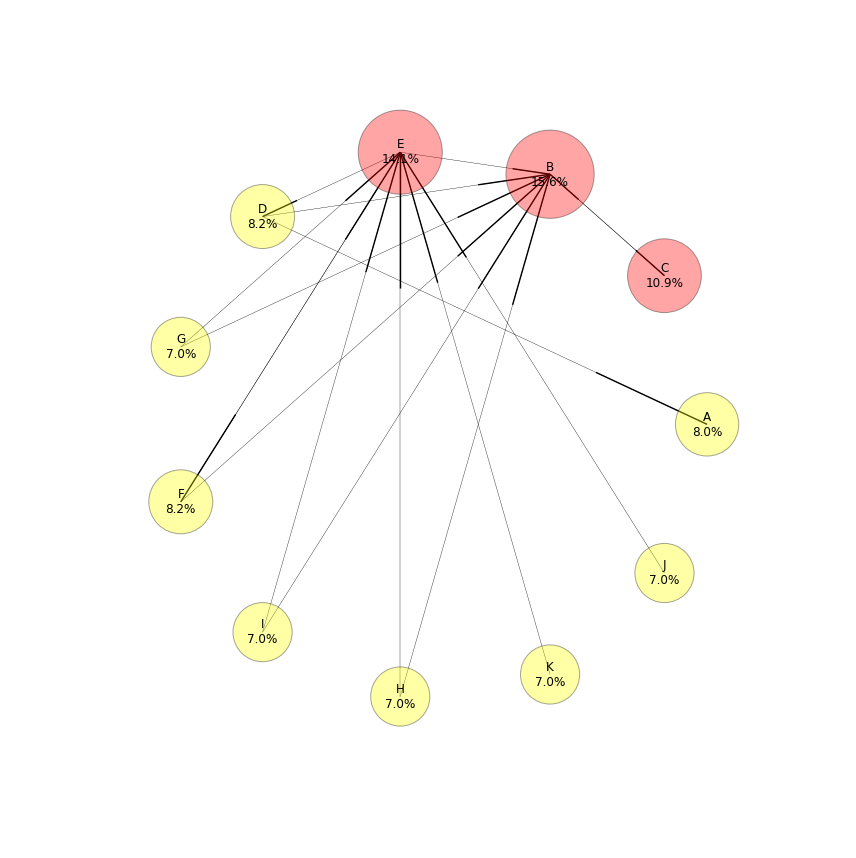

Network graph with damping factor = 0.5


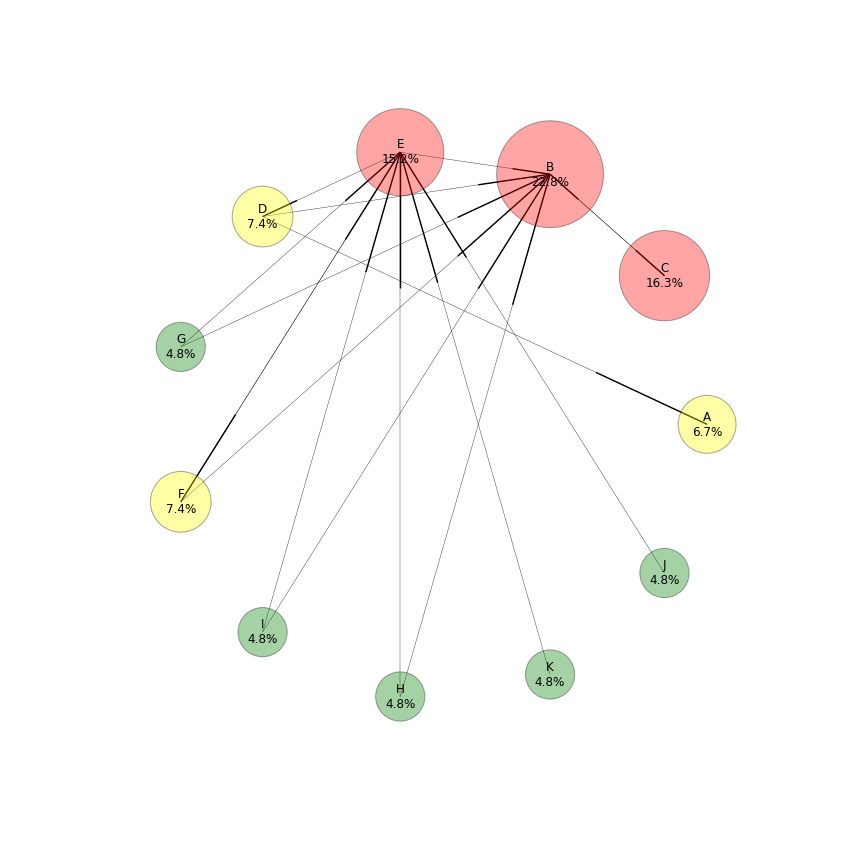

Network graph with damping factor = 0.75


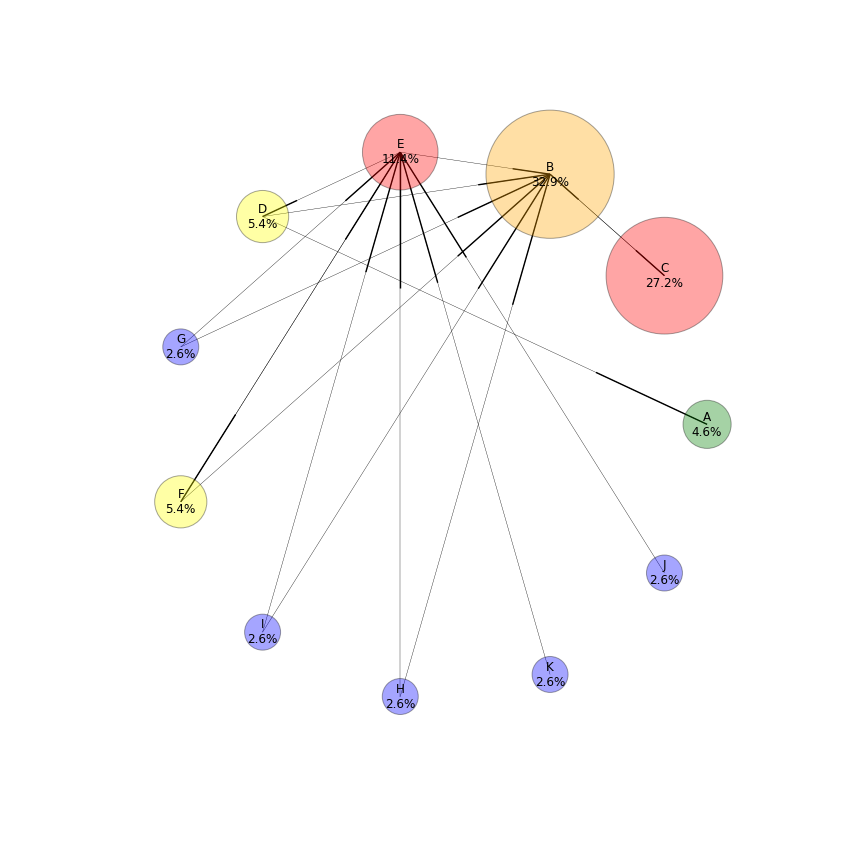

Network graph with damping factor = 0.85


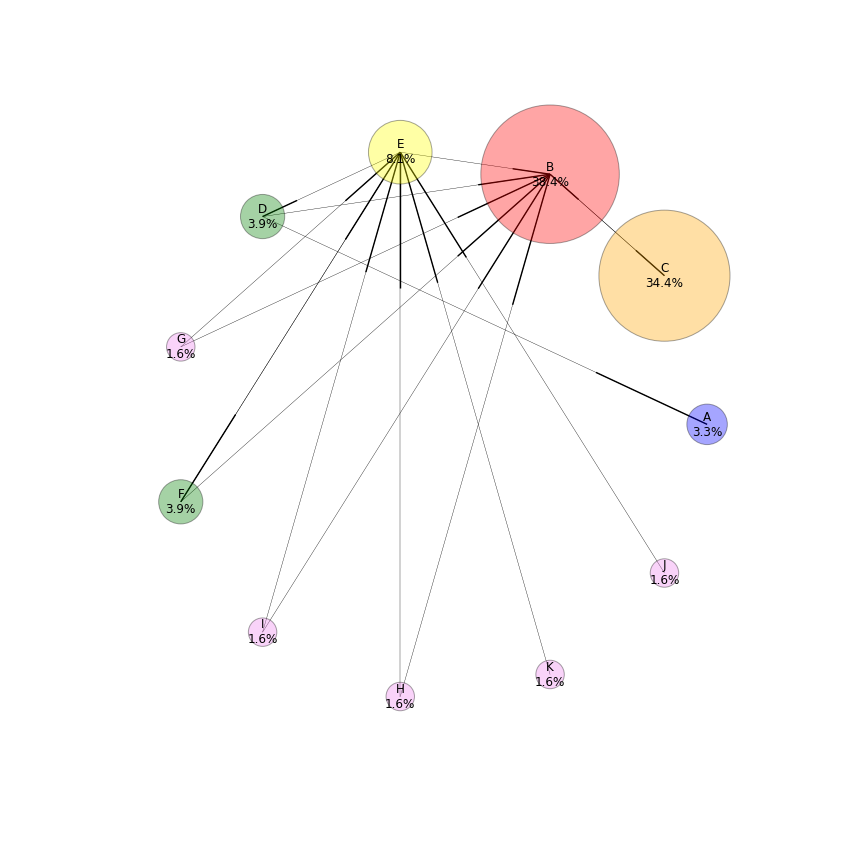

Network graph with damping factor = 1


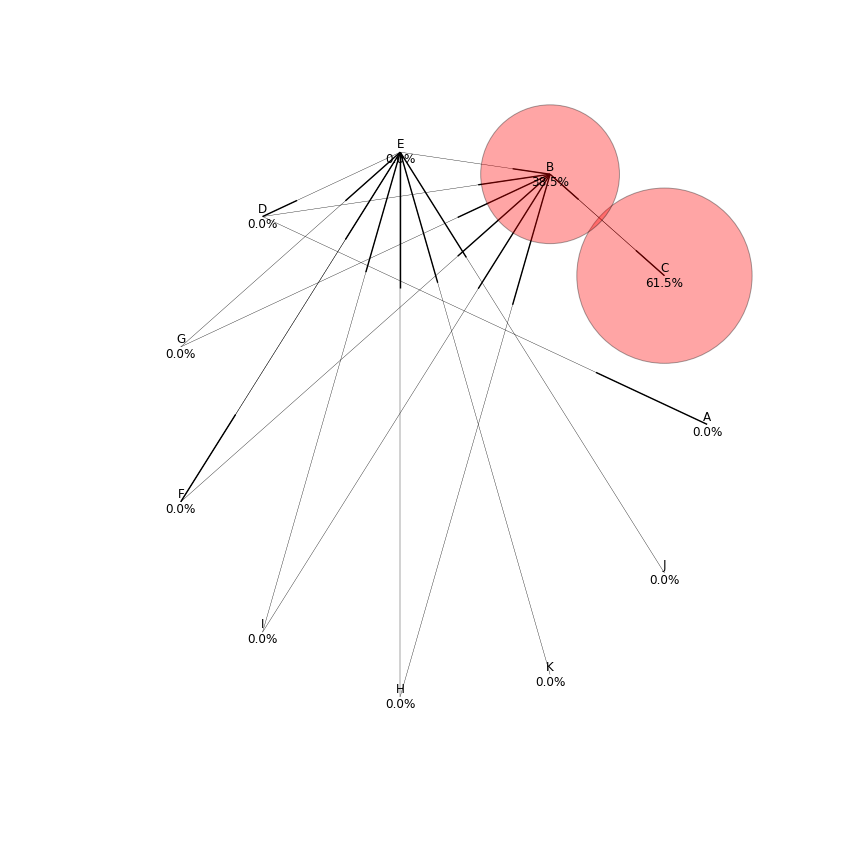

In [11]:
##
# Plot network graph for damping factors: [0,0.25,0.5,0.75, 0.85, 1] with each node's radius proportional to its PageRank score.
##
%matplotlib inline
import networkx as nx
import ast
from matplotlib import pyplot as plt

def plot_graph(graph, pagerank, damping, labels=None):
    plt.figure(figsize=(12, 12))

    Directed_Graph = nx.DiGraph()

    for edge in graph:
        Directed_Graph.add_edge(edge[0], edge[1])
   
    node_size = [pagerank[n]*50000 for n in Directed_Graph.nodes()]

    graph_pos = nx.circular_layout(Directed_Graph)
    #graph_pos=nx.spring_layout(Directed_Graph)

    labels = {}
    node_colors = []

    print "Network graph with damping factor = {}".format(damping)

    for node in Directed_Graph.nodes():
        labels[node] = '{}\n{}'.format(node, str(round(pagerank[node]*100,1))+'%')
        if pagerank[node] <= 0.017:
            node_colors.append('violet')
        if pagerank[node] > 0.017 and pagerank[node] <= 0.038:
            node_colors.append('blue')
        if pagerank[node] > 0.038 and pagerank[node] <= 0.049:
            node_colors.append('green')
        if pagerank[node] > 0.05 and pagerank[node] <= 0.1:
            node_colors.append('yellow')
        if pagerank[node] > 0.3 and pagerank[node] <= 0.35:
            node_colors.append('orange')
        elif pagerank[node] > 0.1:
            node_colors.append('red')

    nx.draw_networkx_nodes(Directed_Graph, graph_pos, node_size = node_size, alpha = 0.35, node_color = node_colors)
    nx.draw_networkx_edges(Directed_Graph, graph_pos, width = 0.35, alpha = 1, edge_color = 'black')
    nx.draw_networkx_labels(Directed_Graph, graph_pos, labels=labels, font_size = 12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    
DAMPING_FACTOR = [0, 0.25, 0.5, 0.75, 0.85, 1]    
graph = []
pagerank = {}
node_dict = {1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J', 11:'K' }
    
for damping in DAMPING_FACTOR:
    input_file = "wikipedia_example_input_with_"+str(damping)+".txt"
    with open (input_file, "r") as f:
        for line in f.readlines():
            line  = line.strip()
            node, pagerank_out_links = line.split('\t')
            node = int(node.strip('"'))
            out_links, pr = map(ast.literal_eval, pagerank_out_links.strip('"').split('|'))
            graph.extend([(node_dict[int(node)], node_dict[int(n) ] ) for n in out_links.keys()])
            pagerank[node_dict[int(node)]] = pr
        plot_graph(graph, pagerank, damping)


        

### Analysis

Using the above implmentation of the iterative PageRank algorithm, with teleportation factor and distribution of the dangling nodes mass, several MRJobs were executed on damping factors: [0,0.25,0.5,0.75, 0.85, 1] and resulted pagerank probablities are plotted with each nodes radius proportional to its PageRank score.

Plots look similar to https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg.


## Section 3: Applying PageRank to the Wikipedia hyperlinks network 

* Run the PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run the PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on the findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


### Section 3 Implementation

### <span style="color:darkRed"> Added code to assign intial pagerank using map reduce </span>


In [1]:
%%writefile WikiInputFile.py


from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

class WikiInputFile(MRJob):
    def steps(self):
        return [MRStep( 
                       mapper=self.mapper
                       )
                ]
    
    def configure_options(self):
        super(WikiInputFile, self).configure_options()
        self.add_passthrough_option('--numtotalnodes', default=None, type=str, help='total number of nodes in the graph')
    
    def mapper(self, _, line):
        node, adj_list = line.split('\t')
        adj_list  = adj_list + '|' + str(1.0/int(self.options.numtotalnodes))
        yield node, adj_list
        
        
if __name__ == '__main__':
    WikiInputFile.run()    
  

Overwriting WikiInputFile.py


In [2]:
%%writefile WikiInputFile_driver.py

from WikiInputFile import WikiInputFile
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import ast
import subprocess

INPUT_GRAPH = sys.argv[1]
TOTAL_NODES = sys.argv[2]


mr_job = WikiInputFile(args=[INPUT_GRAPH,  '--numtotalnodes', TOTAL_NODES,  '-r', 'local' ])
with mr_job.make_runner() as runner: 
    runner.run()
    f = open(INPUT_GRAPH, 'w+')
    for line in runner.stream_output():
        #print line
        f.writelines(line)

f.close()
        

Overwriting WikiInputFile_driver.py


In [3]:
#!hdfs dfs -cat hdfs:///tmp/hw9/wiki_out.txt | head  
!hdfs dfs -cat hdfs:/tmp/hw7/wiki_out.txt | wc -l

5781290


In [4]:
!rm ./wiki_out_input_five.txt
!hdfs dfs -copyToLocal hdfs:/tmp/hw7/wiki_out.txt ./wiki_out_input_five.txt
!python ./WikiInputFile_driver.py ./wiki_out_input_five.txt 5781290

In [5]:
!cat ./wiki_out_input_five.txt | head

"13876063"	"{'8037968': 1, '4582331': 2, '5011905': 1, '5118655': 1, '4730166': 2, '2138559': 1, '1895648': 4, '13841238': 1, '4270538': 1, '10969310': 1, '13704868': 1, '13841200': 1, '10970804': 4, '8039196': 1, '3205568': 2}|1.72971776195e-07"
"13876441"	"{'2437837': 1, '12906477': 1, '3975017': 1, '2964011': 1, '14870214': 1, '28113': 1, '13876253': 1, '7430574': 1, '1477521': 1, '834022': 1, '862916': 1, '7967978': 1, '6150551': 1, '14594286': 1, '14767686': 1, '14787537': 1, '11409216': 1, '14867267': 1, '14704369': 1, '10403495': 1, '15180113': 1, '4537912': 1, '14634719': 1, '9386580': 1, '14768176': 1, '9269949': 1, '4501915': 1, '13450173': 1, '13686273': 1, '8019937': 1, '13620040': 1, '2598156': 1, '15024128': 1, '5981154': 1, '14637725': 1, '13455888': 1, '6126757': 2, '810917': 1, '10739568': 1, '8178977': 1, '15088153': 1, '15137458': 1, '13876366': 1, '15077614': 1, '10333866': 1, '14838238': 1, '15131676': 2, '3385863': 1, '3808015': 2, '2618628': 1, '15161714': 1, '14

In [2]:
!python ./PageRank_driver.py ./wiki_out_input_five.txt 0.85 5781290 5 'hadoop'

Iteration:  1
rm: `/tmp/msannat/temp-output/': No such file or directory
Iteration:  2
17/03/24 03:01:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  3
17/03/24 04:13:06 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  4
17/03/24 05:27:17 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iterat

In [14]:
# python code to include initial page ranks
# if time permits this can be done using a map reduce job
num_lines = sum(1 for line in open('wiki_out.txt'))
with open("wiki_out.txt","r") as f:
    with open("wiki_out_input_ten.txt","w+")  as w:
        for line in f.readlines():
            line  = line.strip('\n') + '|' + str(1.0/num_lines) +'\n'
            w.write(line)

In [ ]:
!python ./PageRank_driver.py ./wiki_out_input_ten.txt 0.85 5781290 10 'hadoop'

Iteration:  1
17/03/24 00:58:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current


In [ ]:
%%writefile TopPageRank.py


from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
from mrjob.protocol import RawProtocol
import re
import math
import ast

class TopPageRank(MRJob):
    
    MRJob.SORT_VALUES = True
    
    def mapper(self, _, line):
        
        node, pageranke_out_links = line.split("\t")
        node =  node.strip('"').strip("'").strip("\"")
        node = re.sub(r'^"|"$', '', node)
        pageranke_out_links = pageranke_out_links.replace('"', '')
        out_links, page_rank =  pageranke_out_links.strip("\"").split('|')
        page_rank =  page_rank.replace('"', '')
        page_rank = ast.literal_eval(page_rank)
        
        #out_links, page_rank = map(ast.literal_eval, pageranke_out_links.strip("\"").strip('"').strip("'").split('|'))
        yield node, float(page_rank)
            

    def reducer(self, node, pageranks):
        pagerank = sum(i for i in pageranks)
        yield node, pagerank
        

    def steps(self):

        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            #'mapreduce.text.key.comparator.options': '-k2,2nr -k1,1',
            'mapred.text.key.comparator.options': '-k2,2nr -k1,1', 
            'mapreduce.job.reduces': 1
        }
        
        return [
              MRStep(jobconf=JOBCONF_STEP,
                    mapper=self.mapper
                    ,reducer=self.reducer)
              ]

    
if __name__ == '__main__':
    TopPageRank.run()




In [ ]:
# RUNNER
from TopPageRank import TopPageRank
import subprocess
results = {}     
mr_job = TopPageRank(args=['-r', 'hadoop', 'hdfs:///tmp/msannat/wiki_out_input_five.txt','--no-output', '--cleanup', 'NONE', '--output-dir',  '/tmp/msannat/temp-output-rank' ])

with mr_job.make_runner() as runner:
    counter = 0
    subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output-rank/"], stdout=None)
    runner.run()
    cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output-rank/part-*"], stdout=subprocess.PIPE)
    f = open('./wiki_out_input_five_top_page_rank.txt', 'w+')
    for line in cat.stdout:
        key, value = mr_job.parse_output_line(line)
        #if counter<1000:
        f.writelines(line)
        #counter+=1
    f.close()

#END RUNNER

In [2]:
#RUNNER
from TopPageRank import TopPageRank
import subprocess
results = {}     
mr_job = TopPageRank(args=['-r', 'hadoop', './wiki_out_input_ten_iteration.txt','--no-output', '--cleanup', 'NONE', '--output-dir',  '/tmp/msannat/temp-output-rank' ])

with mr_job.make_runner() as runner:
    counter = 0
    subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output-rank/"], stdout=None)
    runner.run()
    cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output-rank/part-*"], stdout=subprocess.PIPE)
    f = open('./wiki_out_input_ten_top_page_rank.txt', 'w+')
    for line in cat.stdout:
        key, value = mr_job.parse_output_line(line)
        if counter<1000:
            f.writelines(line)
            counter+=1
    f.close()

#END RUNNER

In [18]:
import subprocess
from collections import defaultdict
from collections import OrderedDict
def ind_lookup(path):
    node_words = {}
    cat = subprocess.Popen(["hadoop", "fs", "-cat", "hdfs:/tmp/hw7/wiki_indices.txt"], stdout=subprocess.PIPE)
    for line in cat.stdout:
        word,index,temp1,temp2 = line.strip().split("\t")
        if int(index) in path:
            node_words[index] = word
    return node_words 

input_file = './wiki_out_input_five_top_page_rank.txt'
global node_pr
global path

path= []
node_pr = {}
node_articles = {}
with open (input_file, "r") as f:
    for line in f.readlines():
        #print line
        line  = line.strip()
        pagerank, node  = line.split('\t')
        pagerank = pagerank.replace('"', '')
        pagerank = float(pagerank)
        node = node.replace('"', '')
        node = int(node.strip("'").strip('"'))
        
        path.append(node)
        node_pr[node] = pagerank
#print type(path)
        
node_articles =  ind_lookup(path)

print '*******************************************************************'
print 'Top 100 ranked nodes (with alpha = 0.85) for 5 iterations'
print '*******************************************************************'
print 'Node\t\tPageRank\t\tArticle'
for node in path:
    print('%d \t%f \t%s ' % (node, node_pr[node], node_articles[str(node)]))
print '*******************************************************************'


*******************************************************************
Top 100 ranked nodes (with alpha = 0.85) for 5 iterations
*******************************************************************
Node		PageRank		Article
13455888 	0.000022 	United States 
12836211 	0.000015 	The New York Times 
6172466 	0.000010 	Iran 
13425865 	0.000009 	United Kingdom 
4198751 	0.000009 	English language 
7467127 	0.000008 	Latin 
2797855 	0.000008 	China 
2578813 	0.000007 	Catholic Church 
14112583 	0.000007 	World War II 
1300106 	0.000007 	Arabic 
9386580 	0.000007 	New York City 
13853369 	0.000006 	Washington, D.C. 
13432150 	0.000006 	United States Census Bureau 
11253108 	0.000006 	Russia 
12067030 	0.000006 	Soviet Union 
4695850 	0.000006 	France 
5051368 	0.000005 	Germany 
14112408 	0.000005 	World War I 
13429704 	0.000005 	United Nations 
2437837 	0.000005 	Canada 
4350909 	0.000005 	European Union 
4344962 	0.000005 	Europe 
12905382 	0.000005 	The Washington Post 
11197411 	0.000005 	Rov

### Section 3 Analysis

The altiscale job for 10 iterations couldn't finish with repeated interruptins (mostly loss of innternet connection)  but comparing output from different iterations it seems that top 100 ranked nodes remained same with some change in their ranks after each iteration.

## Section 4: Topic-specific PageRank implementation using MRJob 

Modify the PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)   
> `wget http://ucb-mids-mls-networks.s3.amazonaws.com/randNet.txt`

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)   
> `wget http://ucb-mids-mls-networks.s3.amazonaws.com/randNet_topics.txt`

Since there are 10 topics, the result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on the result. Assume a teleportation factor of 0.15 in all the analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, I will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

### Section 4 Implementation

### <span style="color:darkRed"> Added code to assign intial pagerank using map reduce </span>

In [6]:
%%writefile WikiInputFile94.py


from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

class WikiInputFile94(MRJob):
    def steps(self):
        return [MRStep( mapper=self.mapper )
                ]
    
    def configure_options(self):
        super(WikiInputFile94, self).configure_options()
        self.add_passthrough_option('--numtotalnodes', default=None, type=str, help='total number of nodes in the graph')
        self.add_passthrough_option('--numtotaltopics', default=None, type=str, help='total number of nodes in the graph')
    
    def mapper(self, _, line):
        node, adj_list = line.split('\t')
        adj_list  = adj_list + '|' + str([1.0/int(self.options.numtotalnodes)] * (int(self.options.numtotaltopics) + 1))
        yield node, adj_list
        
if __name__ == '__main__':
    WikiInputFile94.run()    
 

Overwriting WikiInputFile94.py


In [7]:
%%writefile WikiInputFile94_driver.py

from WikiInputFile94 import WikiInputFile94
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import ast
import subprocess

INPUT_GRAPH = sys.argv[1]
TOTAL_NODES = sys.argv[2]
TOTAL_TOPICS = sys.argv[3]


mr_job = WikiInputFile94(args=[INPUT_GRAPH,  '--numtotalnodes', TOTAL_NODES, '--numtotaltopics', TOTAL_TOPICS,  '-r', 'local' ])
with mr_job.make_runner() as runner: 
    runner.run()
    f = open(INPUT_GRAPH, 'w+')
    for line in runner.stream_output():
        #print line
        f.writelines(line)

f.close()
        

Overwriting WikiInputFile94_driver.py


In [8]:
!cat ./randNet_topics_updated.txt | wc -l

100


In [9]:
!rm ./randNet_topics_updated_topics.txt.txt
!cp ./randNet_topics_updated.txt ./randNet_topics_updated_topics.txt.txt
!python ./WikiInputFile94_driver.py ./randNet_topics_updated_topics.txt 100 10

rm: cannot remove `./randNet_topics_updated_topics.txt.txt': No such file or directory


In [10]:
!cat ./randNet_topics_updated_topics.txt

"55"	"{u'77': 1, u'12': 1, u'32': 1, u'34': 1, u'1': 1, u'3': 1, u'47': 1, u'84': 1}|7|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]"
"56"	"{u'27': 1, u'15': 1, u'46': 1, u'32': 1, u'31': 1, u'52': 1, u'68': 1, u'84': 1}|6|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]"
"57"	"{u'43': 1, u'52': 1, u'61': 1, u'63': 1, u'80': 1, u'78': 1}|9|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]"
"58"	"{u'21': 1, u'33': 1, u'56': 1, u'28': 1, u'43': 1, u'52': 1, u'2': 1, u'6': 1, u'83': 1, u'94': 1, u'74': 1}|2|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]"
"59"	"{u'25': 1, u'17': 1, u'23': 1, u'55': 1, u'44': 1, u'50': 1, u'40': 1, u'52': 1, u'73': 1, u

In [ ]:
%%writefile PageRankTopics.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

class PageRankTopics(MRJob):
    
    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            #'mapreduce.text.key.comparator.options': '-k2,2nr -k1,1',
            #'mapred.text.key.comparator.options': '-k2,2nr -k1,1', 
            'mapreduce.job.reduces': 1
        }
        
      
        return [MRStep(jobconf=JOBCONF_STEP1, 
                       mapper=self.mapper, 
                       reducer=self.reducer),
                MRStep(reducer_init=self.reducer_pagerank_init,
                       reducer=self.reducer_pagerank)
                ]
        
        
    
    
    def configure_options(self):
        super(PageRankTopics, self).configure_options()
        self.add_passthrough_option('--dampingfactor', default='0.85', type=str, help='damping factor')
        self.add_passthrough_option('--numtotalnodes', default=None, type=str, help='total number of nodes in the graph')
        self.add_passthrough_option('--numtopics', default='10', type=str, help='total number of topics')
        self.add_passthrough_option('--beta', default='0.98', type=str, help='beta factor')
        self.add_file_option('--topic_counts', help='topic counts file')
    
    
    def mapper(self, _, line):
        pass
        
        node = None
        adjacency_list = None
        initial_page_rank = 0.0
        neighbors = 0
        page_rank_list = []
        
        topic = ""
        
        if line!= "":
            node, graph_pr_out_links = line.strip().split('\t')
            node =  node.replace('"', '')
        
            adjacency_list, topic, page_rank_list, = map(ast.literal_eval, graph_pr_out_links.strip("\"").strip('"').strip("'").split('|'))
            neighbors = len(adjacency_list)
             
            if neighbors> 0:
                page_rank_updated =  [page_rank*1.0/neighbors for page_rank in page_rank_list]
                for key in adjacency_list.keys():
                    yield (key),  (page_rank_updated)
                    
            if neighbors== 0:
                yield '**dangling', (page_rank_list) 
                
            yield (node), (graph_pr_out_links)
        
        
    
    def reducer(self, key, values):
        node = None
        adjacency_list = {}
        total = 0.0
        node =  key.strip("'")
        lost_mass = [0] * (int(self.options.numtopics) + 1)
        updated_page_rank = [0] * (int(self.options.numtopics) + 1)
        
        if key == '**dangling':
            for value in values:
                for j in range(len(value)):
                    lost_mass[j]+= float(value[j])
            
            for i in range(1, int(self.options.numtotalnodes) + 1):
                yield str(i), lost_mass
        
        else:
            for value in values:
                if type(value) == list:
                    for k in range(len(value)):
                        updated_page_rank[k]+= float(value[k])
                else:
                    adjacency_list, topic, page_rank_ori = map(ast.literal_eval, value.strip("\"").strip('"').strip("'").split('|'))

            yield node , (str(adjacency_list) + '|' + str(topic)  + '|' + str(updated_page_rank) )
        
    
    def reducer_pagerank_init(self):
        self.topic_counts = {}        
        with open('topic_counts.txt', 'r') as topic_counts:
            for line in topic_counts.readlines():
                count, topic  = line.strip().split("\t")
                self.topic_counts[int(topic)] = int(count)
        
    
    def reducer_pagerank(self, node, pagerank_adj_list):
        lost_mass = [0] * (int(self.options.numtopics) + 1)

        page_rank_updated = []
        adj_list = {}
        num_topics = int(self.options.numtopics) + 1
        
        alpha = 1 - float(self.options.dampingfactor)
        total_nodes = float(self.options.numtotalnodes)
        beta = float(self.options.beta)
        
        for pagerank_link in pagerank_adj_list:
            if type(pagerank_link) == list:
                lost_mass = pagerank_link
            else:
                adj_list, topic, pagerank = map(ast.literal_eval, pagerank_link.strip("\"").split('|'))
        
        for topic_num in range(1, num_topics):
            curr_topic = self.topic_counts[topic_num]
            #yield node, self.topic_counts[topic_num]
            
            if (topic_num) == int(topic):
                #pass
                page_rank_updated.append(alpha * (beta/curr_topic) + (1-alpha) * (lost_mass[topic_num-1]/total_nodes + float(pagerank[topic_num-1])))
            else:
                page_rank_updated.append(alpha * ((1-beta)/(total_nodes-curr_topic)) + (1-alpha) * (lost_mass[topic_num-1]/total_nodes + float(pagerank[topic_num-1])))

        page_rank_updated.append(alpha * (1/total_nodes) + (1-alpha) * (lost_mass[topic_num-1]/total_nodes + float(pagerank[topic_num-1])))
                
        yield node, str(adj_list) + "|" + str(topic) + "|" + str(page_rank_updated)
                
        
            
if __name__ == '__main__':
    PageRankTopics.run()    
  

In [ ]:
%%writefile PageRankTopics_driver.py

from PageRankTopics import PageRankTopics
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import ast
import subprocess

INPUT_GRAPH = sys.argv[1]
DAMPING_FACTOR = sys.argv[2]
TOTAL_NODES = sys.argv[3]
MAX_ITERATION = int(sys.argv[4])
MODE = sys.argv[5]

num_interation = 0

if MODE == 'hadoop':
    mr_job = PageRankTopics(args=[INPUT_GRAPH, '--dampingfactor', DAMPING_FACTOR, '--numtotalnodes', TOTAL_NODES,  '-r', 'hadoop', 
                                  '--topic_counts', 'topic_counts.txt', '--no-output', '--cleanup', 'NONE', '--no-check-input-paths', '--output-dir',  '/tmp/msannat/temp-output' ])
    while (num_interation<MAX_ITERATION):
        with mr_job.make_runner() as runner: 
            num_interation += 1
            print "Iteration: ", num_interation
            subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
            runner.run()
            f = open(INPUT_GRAPH, 'w+')
            cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
            for line in cat.stdout:
                #print line
                f.writelines(line)

        f.close()
        
        
else:
    mr_job = PageRankTopics(args=[INPUT_GRAPH, '--dampingfactor', DAMPING_FACTOR, '--numtotalnodes', TOTAL_NODES, 
                                  '--topic_counts', './topic_counts.txt',  '-r', 'local' ])
    while (num_interation<MAX_ITERATION):
        with mr_job.make_runner() as runner: 
            num_interation += 1
            print "Iteration: ", num_interation
            runner.run()
            f = open(INPUT_GRAPH, 'w+')
            for line in runner.stream_output():
                #print line
                f.writelines(line)

        f.close()
        


In [ ]:
!rm ./randNet_topics_input.txt
!cp ./randNet_topics_updated_topics.txt ./randNet_topics_input.txt
!python ./PageRankTopics_driver.py ./randNet_topics_input.txt 0.85 100 100 'local'

In [27]:
import ast
import sys

topic_page_ranks = []
i = 0

with open('./randNet_topics_input.txt', 'r') as topics_pr_file:
    for line in topics_pr_file.readlines():
        node, pr_out_links = line.split('\t')
        pr_out_links =  pr_out_links.replace('"', '')
        node = node.replace('"', '')
        out_links, topic, pr = map(ast.literal_eval, pr_out_links.split('|'))
        top_pages_topics = []
        top_pages_topics.extend([int(node), topic])
        for i in range (0, 11):
            top_pages_topics.append(float(pr[i]))
        topic_page_ranks.append(top_pages_topics)
        
        
print '*************************************'
print "Top 10 pages for Global Page rank"
print '**************************************'

for pr in sorted(topic_page_ranks, key=lambda x: x[12], reverse=True)[:10]:
    print "{0: <4} {1: <4} {2}".format(pr[0], pr[1], round(pr[12], 4))
        
for i in range(10):
    print '************************************'
    print "Top 10 pages for Topic {}".format(i+1)
    print '************************************'
    for pr in sorted(topic_page_ranks, key=lambda x: x[i+2], reverse=True)[:10]:
        print "{0: <4} {1: <4} {2}".format(pr[0], pr[1], round(pr[i+2], 4))
        

*************************************
Top 10 pages for Global Page rank
**************************************
63   4    0.0184
61   8    0.0172
15   3    0.0165
74   10   0.0155
92   1    0.0149
100  8    0.0149
90   5    0.0147
13   6    0.0145
85   7    0.0143
71   2    0.0141
************************************
Top 10 pages for Topic 1
************************************
32   1    0.0206
77   1    0.0205
52   1    0.0197
92   1    0.0195
10   1    0.0185
27   1    0.0184
85   7    0.0178
98   1    0.0176
46   1    0.0174
74   10   0.016
************************************
Top 10 pages for Topic 2
************************************
58   2    0.0307
71   2    0.0295
9    2    0.0291
73   2    0.0287
12   2    0.0267
59   2    0.0256
75   2    0.0247
82   2    0.0227
52   1    0.0163
17   10   0.0151
************************************
Top 10 pages for Topic 3
************************************
15   3    0.0314
70   3    0.0269
86   3    0.0264
91   3    0.0243
66   3    0.024

### Section 4 Analysis

As expected, pages assoaciated with a specifc topic ranks higher and the vanila global page ranks are different than the page ranks for topics.

Literature's method for irreducibility is difficult to implement with topic-specific PageRank as it will required to be performed for each topic making it very computationally expesive.


<center><div class='jumbotron'>-------  END OF HWK 9 --------</div></center>